# 1. Environment

In [1]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from PIL import Image
import random
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import multiprocessing

In [2]:
sns.set(style="darkgrid", context="notebook", palette="muted")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 2. Load

In [5]:
input_path = Path("../input")
train_imgs_path = input_path / "processed_train"
print("Train Images:%d" % len(list(train_imgs_path.glob("*jpg"))))
train = pd.read_csv("../input/train.csv")

Train Images:3881


# 3. Feature Engineering

## Check Training Images

In [6]:
train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 2 columns):
image_id    3881 non-null object
labels      3605 non-null object
dtypes: object(2)
memory usage: 60.8+ KB


Some `labels` seem to contain `NaN` in `train`.  
We check showing top-6 images containing `NaN` at `labels`.

In [8]:
train_nan_labels = train[train["labels"].isnull()]
train_nan_labels.head(6)

,image_id,labels
66,100241706_00038_2,NaN
67,100241706_00039_1,NaN
68,100241706_00039_2,NaN
69,100241706_00040_1,NaN
73,100249371_00003_2,NaN
74,100249371_00004_1,NaN


In [9]:
train_nan_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 66 to 3880
Data columns (total 2 columns):
image_id    276 non-null object
labels      0 non-null object
dtypes: object(2)
memory usage: 6.5+ KB


In [10]:
# fig = plt.figure(figsize=(20, 80))
# for i in range(6):
#     image_id = train_nan_labels["image_id"].iloc[i]
#     file_name = image_id + ".jpg"
#     train_img_path = train_imgs_path / file_name
#     train_img = np.asarray(Image.open(train_img_path))
#     fig.add_subplot(1, 6, i+1, title=file_name)
#     plt.axis("off")
#     plt.imshow(train_img)
# plt.show()

It seem to contain no characters in `NaN` label's images.  
Therefore, we can delete them all and reset the index.

In [11]:
train = train.dropna()
train = train.reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605 entries, 0 to 3604
Data columns (total 2 columns):
image_id    3605 non-null object
labels      3605 non-null object
dtypes: object(2)
memory usage: 56.5+ KB


We use **3605** training images.

## Create Characters Data

In [12]:
train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


From [Data Description](https://www.kaggle.com/c/kuzushiji-recognition/data),

> The string should be read as space separated series of values where `Unicode character`, `X`, `Y`, `Width`, and `Height` are repeated as many times as necessary.

We create a dictionary `train_chars` where the key is `image_id` and the value is a dictionary containing `Unicode character`, `X`, `Y`, `Width` and `Height`.

In [13]:
train_chars = {}
uc_list = []
train_chars_num = 0
for i in tqdm(range(train.shape[0])):
    image_id = train.iloc[i]["image_id"]
    labels = train.iloc[i]["labels"].split(" ")
    values = {"Unicode" : [],
              "X" : [],
              "Y" : [],
              "Width" : [],
              "Height" : []}
    for j in range(0, len(labels), 5):
        uc = labels[j]
        x = int(labels[j+1])
        y = int(labels[j+2])
        w = int(labels[j+3])
        h = int(labels[j+4])
        uc_list.append(uc)
        values["Unicode"].append(uc)
        values["X"].append(x)
        values["Y"].append(y)
        values["Width"].append(w)
        values["Height"].append(h)
        train_chars_num += 1
    train_chars[image_id] = values
train_chars_num

683464

In [14]:
the_id = list(train_chars.keys())
the_id = the_id[0]
the_label = train_chars[the_id]
print(the_id)
print("({}, {}, {}, {})".format(the_label['X'][0],
                                the_label['Y'][0],
                                the_label['Width'][0],
                                the_label['Height'][0]))

100241706_00004_2
(1231, 3465, 133, 53)


In [15]:
def read_image(image_id, labels):
    image = Image.open('../input/processed_train/{}.jpg'.format(image_id))
    xy_list = []
    labels_zip = zip(labels["Unicode"],
                     labels["X"],
                     labels["Y"],
                     labels["Width"],
                     labels["Height"])
    for uc, x, y, w, h in labels_zip:
        # Crop as Character's PIL Image
        char_img = image.crop((x, y, x+w, y+h))
#         # Gray-Scale Character's PIL Image where the channel is 1
#         char_img = char_img.convert('L')
#         # Resize Character's PIL Image
#         char_img = char_img.resize((48, 48))
        # Add Training Data
        char_img = np.asarray(char_img)
        xy_list.append((char_img, uc))
    return xy_list

In [16]:
%%time

pool = multiprocessing.Pool(processes=8)
result = []
for key, values in train_chars.items():
    result.append(pool.apply_async(read_image, (key, values,)))
pool.close()
pool.join()
char_uc_list = []
for res in result:
    xy_list = res.get()
    char_uc_list += xy_list

len(char_uc_list)

CPU times: user 2.56 s, sys: 1.46 s, total: 4.03 s
Wall time: 12.6 s


683464

We get **683464** character images(seems to be too large).  

## Check Unicodes

In [17]:
uc_trans = pd.read_csv(input_path / "unicode_translation.csv")
uc_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 2 columns):
Unicode    4787 non-null object
char       4787 non-null object
dtypes: object(2)
memory usage: 74.9+ KB


There are 4787 classes of all unicode characters.  
However, some characters might be useless in training images.  
We check useless unicodes which are in `uc_trans["Unicode"]` and are not in all unicodes of `train_chars`.

In [18]:
uc_list = set(uc_list)
uc_trans = uc_trans[uc_trans['Unicode'].isin(uc_list)]
uc_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4212 entries, 5 to 4786
Data columns (total 2 columns):
Unicode    4212 non-null object
char       4212 non-null object
dtypes: object(2)
memory usage: 98.7+ KB


There seems to be 575 useless unicodes in training images.  
Finally, we shrink `uc_trans` from 4787 classes to **4212**(=4787-575).

We create a list of unicode `uc_list` whose index is used for training and test labels.

In [19]:
uc_list = uc_trans["Unicode"].values.tolist()
uc_list.index("U+306F")

84

# 4. Create Pytorch Dataset

We define `KuzushijiCharDataset` class extended from `torch.utils.data.Dataset`.  
As it costs little time to get i-th training data, it creates as follows.
1. Open PIL Image each `image_id`
2. Crop as Character's PIL Image
3. Resize Character's PIL Image
4. Gray-Scale Character's PIL Image where the channel is 1
5. Convert from Character's PIL Image to Tensor

In [20]:
class KuzushijiCharDataset(Dataset):
    def __init__(self,
                 data_list: list,
                 uc_list: list,
                 image_path: Path,
                 scale_resize: tuple,
                 transform=None):
        self._image_list = []
        self._y_list = []
        self.scale_resize = scale_resize
        self.transform = transform
                
        for image, uc in tqdm(data_list):
            self._image_list.append(image)
            # Add Training Label
            uc_idx = uc_list.index(uc)
            self._y_list.append(uc_idx)
            

    def __len__(self):
        return len(self._y_list)
    
    def __getitem__(self, idx: int):
        char_img = self._image_list[idx]
        if self.transform:
            char_img = self.transform(image=char_img)['image']
        else:
            # Resize Character's PIL Image
            char_img = Image.fromarray(char_img)
            char_img = char_img.resize(self.scale_resize)
        # Convert to Tensor
        x = transforms.functional.to_tensor(char_img)
        y = self._y_list[idx]
        return x, y

Some width or height are too large.  
For the time being, we decide the resizing scale by fixed values(=48).

In [21]:
w_resize = 64
h_resize = 64

BATCH_SIZE = 512

In [22]:
xy_train, xy_val = train_test_split(char_uc_list, test_size=0.05)
print(len(xy_train))
print(len(xy_val))

649290
34174


In [23]:
from albumentations import (Compose, ShiftScaleRotate, RGBShift, Cutout, Resize)

In [24]:
# 1. RGBShift
# 2. ShiftScaleRotate
# 3. Resize
# 3. Cutout

def augment_char_images(p=.5):
    return Compose([
#         RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=p),
        ShiftScaleRotate(shift_limit=0.05, rotate_limit=10, p=p),
        Resize(height=h_resize, width=w_resize, always_apply=True),
        Cutout(num_holes=5, max_h_size=5, max_w_size=5, fill_value=0, p=p)
    ], p=p)

In [25]:
# char_transform = transforms.Compose([
#     transforms.Resize(52), 
#     transforms.RandomCrop(48),])

char_transform = augment_char_images(1)
# char_transform = None

In [26]:
dataloaders = {'train': DataLoader(KuzushijiCharDataset(data_list=xy_train,
                                                        uc_list=uc_list,
                                                        image_path=train_imgs_path,
                                                        scale_resize=(w_resize, h_resize),
                                                        transform=char_transform),
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=8),
               'val': DataLoader(KuzushijiCharDataset(data_list=xy_val,
                                                      uc_list=uc_list,
                                                      image_path=train_imgs_path,
                                                      scale_resize=(w_resize, h_resize)),
                                 batch_size=BATCH_SIZE,
                                 shuffle=False,
                                 num_workers=8)}

In [27]:
# for i_batch, sample_batched in enumerate(dataloaders['train']):
#     new_img, old_img = sample_batched

#     new_img = np.array(new_img[0])
#     new_img = np.moveaxis(new_img, 0, 2)
#     print(new_img.shape)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(new_img)
#     plt.show()
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(old_img[0])
#     plt.show()
#     break

In [28]:
# from fastai.vision import *

In [29]:
# test_data = DataBunch(train_dl=dataloaders['train'], valid_dl=dataloaders['val'], device=device)

# 5. Demonstration for Classifying Characters

## Create Network

In [30]:
import torchvision.models as models

class DemoModel(torch.nn.Module):
    def __init__(self , model):
        super(DemoModel, self).__init__()
        self.input = torch.nn.Conv2d(1, 3, 3, stride=1, padding=1)
        self.resnet_layer = torch.nn.Sequential(*list(model.children())[:-2])
        self.fc_ = torch.nn.Linear(2048, 4212)
        
    def forward(self, x):
        x = self.input(x)
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_(x)
        
        return x

In [31]:
resnet = models.resnet18(pretrained=True)
model = DemoModel(resnet)
model.to(device)
model

DemoModel(
  (input): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

## Define Training Parameters

In [32]:
from torch.optim.lr_scheduler import StepLR

In [33]:
max_epochs = 20
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

In [34]:
# TODO: 1. fastai
# TODO: 2. 添加early stop

## Train

In [35]:
%%time
result = {"Epoch" : [],
          "Type" : [],
          "Average Loss" : [],
          "Accuracy" : []}

for epoch in range(1, max_epochs+1):
    # Training
    running_loss = 0.0
    running_acc = 0.0
    count = 0
    model.train()
    for inputs, labels in tqdm(dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        count += 1
        pred = outputs.argmax(dim=1)
        acc = torch.eq(pred, labels).sum().float().item()
        running_acc += acc / inputs.size(0)
    scheduler.step()
    avg_loss = running_loss / count
    avg_acc = running_acc / count
    result["Epoch"].append(epoch)
    result["Type"].append("Training")
    result["Average Loss"].append(avg_loss)
    result["Accuracy"].append(avg_acc)
    args = (epoch, max_epochs, datetime.now().isoformat(), avg_loss, avg_acc)
    print("Epoch: %d/%d, Time: %s\nTraining, Loss:%.4f, Accuracy:%.4f" % args)

    # Validation
    running_loss = 0.0
    running_acc = 0.0
    count = 0
    model.eval()
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        count += 1
        pred = outputs.argmax(dim=1)
        acc = torch.eq(pred, labels).sum().float().item()
        running_acc += acc / inputs.size(0)
    avg_loss = running_loss / count
    avg_acc = running_acc / count
    result["Epoch"].append(epoch)
    result["Type"].append("Validation")
    result["Average Loss"].append(avg_loss)
    result["Accuracy"].append(avg_acc)
    args = (avg_loss, avg_acc)
    print("Validation, Loss:%.4f, Accuracy:%.4f" % args)

torch.save(model.state_dict(), '../cache/classify_resnet18_test.pth')


Epoch: 1/20, Time: 2019-10-09T10:12:00.229175
Training, Loss:1.0430, Accuracy:0.7924
Validation, Loss:0.5912, Accuracy:0.8649



Epoch: 2/20, Time: 2019-10-09T10:15:09.976731
Training, Loss:0.4460, Accuracy:0.8906
Validation, Loss:0.5014, Accuracy:0.8825



Epoch: 3/20, Time: 2019-10-09T10:18:19.900745
Training, Loss:0.3502, Accuracy:0.9098
Validation, Loss:0.4612, Accuracy:0.8951



Epoch: 4/20, Time: 2019-10-09T10:21:29.850030
Training, Loss:0.2243, Accuracy:0.9376
Validation, Loss:0.4262, Accuracy:0.9035



Epoch: 5/20, Time: 2019-10-09T10:24:39.785287
Training, Loss:0.2188, Accuracy:0.9401
Validation, Loss:0.4045, Accuracy:0.9114



Epoch: 6/20, Time: 2019-10-09T10:27:49.686444
Training, Loss:0.1074, Accuracy:0.9688
Validation, Loss:0.3874, Accuracy:0.9210



Epoch: 7/20, Time: 2019-10-09T10:30:59.710432
Training, Loss:0.0853, Accuracy:0.9748
Validation, Loss:0.3916, Accuracy:0.9210



Epoch: 8/20, Time: 2019-10-09T10:34:09.553794
Training, Loss:0.0771, Accuracy:0.9771
Validation, Loss:0.4041, Accuracy:0.9234



Epoch: 9/20, Time: 2019-10-09T10:37:19.447287
Training, Loss:0.0681, Accuracy:0.9794
Validation, Loss:0.4056, Accuracy:0.9230



Epoch: 10/20, Time: 2019-10-09T10:40:29.373845
Training, Loss:0.0609, Accuracy:0.9813
Validation, Loss:0.3958, Accuracy:0.9253



Epoch: 11/20, Time: 2019-10-09T10:43:39.297625
Training, Loss:0.0513, Accuracy:0.9843
Validation, Loss:0.4217, Accuracy:0.9256



Epoch: 12/20, Time: 2019-10-09T10:46:49.173811
Training, Loss:0.0492, Accuracy:0.9848
Validation, Loss:0.4232, Accuracy:0.9257



Epoch: 13/20, Time: 2019-10-09T10:49:59.043290
Training, Loss:0.0480, Accuracy:0.9850
Validation, Loss:0.4261, Accuracy:0.9262



Epoch: 14/20, Time: 2019-10-09T10:53:08.974417
Training, Loss:0.0476, Accuracy:0.9853
Validation, Loss:0.4320, Accuracy:0.9265



Epoch: 15/20, Time: 2019-10-09T10:56:18.852916
Training, Loss:0.0461, Accuracy:0.9857
Validation, Loss:0.4304, Accuracy:0.9250



Epoch: 16/20, Time: 2019-10-09T10:59:28.746308
Training, Loss:0.0447, Accuracy:0.9861
Validation, Loss:0.4341, Accuracy:0.9255



Epoch: 17/20, Time: 2019-10-09T11:02:38.648245
Training, Loss:0.0446, Accuracy:0.9860
Validation, Loss:0.4349, Accuracy:0.9259



Epoch: 18/20, Time: 2019-10-09T11:05:48.553496
Training, Loss:0.0446, Accuracy:0.9861
Validation, Loss:0.4445, Accuracy:0.9254



Epoch: 19/20, Time: 2019-10-09T11:08:58.524162
Training, Loss:0.0443, Accuracy:0.9861
Validation, Loss:0.4361, Accuracy:0.9255



Epoch: 20/20, Time: 2019-10-09T11:12:08.433096
Training, Loss:0.0449, Accuracy:0.9861
Validation, Loss:0.4437, Accuracy:0.9255
CPU times: user 50min 30s, sys: 12min 55s, total: 1h 3min 25s
Wall time: 1h 3min 16s


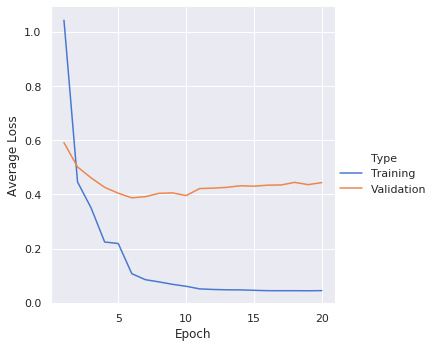

In [36]:
sns.relplot(x="Epoch",
            y="Average Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result))

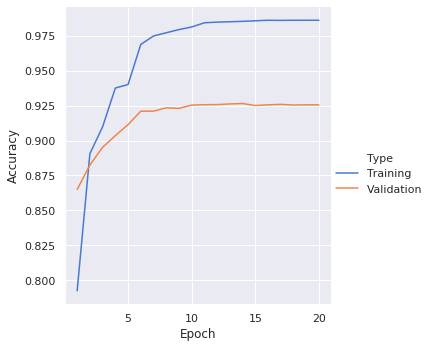

In [37]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result))